In [1]:
### SIMULATETWINSTARINFERENCE.IPYNB -- do end-to-end twin star inference ###

In [2]:
# load packages

import numpy as np
import scipy.special
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scipy.stats as stats
from time import time
import emcee
import pandas as pd
import os

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

sns.set_palette('Set1',color_codes=True)

In [3]:
SCENARIO = 'O4' # O4, O5, 3G
SCENARIOTAG = '' # can add y2, d1, w1, m1 tags to make O5y2 or 3Gd1, 3Gw1, 3Gm1
BASE_EOS = 'SKI5'
HYBRID_EOS = '2009'
VERSION_TAG = ''

In [4]:
# import bilby and lal

#! python3 -m pip install bilby # only need to run this once
#! python3 -m pip install lalsuite # only need to run this once

import bilby
import lal
import lalsimulation as lalsim
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15 as cosmo

In [5]:
# define constants

G = 6.67e-8
c = 2.998e10
Msol = 1.99e33

if VERSION_TAG == '': np.random.seed(0)
else: np.random.seed(int(VERSION_TAG[-1]))

In [6]:
# user scenario input

num_pop = {'O4': 3, 'O5': 2*15, '3G': 5800}[SCENARIO] # number of events to draw; based on astrophysical rate estimates within detector horizon
# see https://arxiv.org/abs/2204.07592, https://arxiv.org/abs/2204.12504, https://arxiv.org/abs/2003.04880, https://arxiv.org/abs/2111.03634, https://arxiv.org/abs/1304.0670, https://arxiv.org/abs/2109.09882

detailed_num_pop = {'O4': 3, 'O5': 15, 'O5y2': 30, '3Gd1': 16, '3Gw1': 112, '3Gm1': 484, '3G': 5800}[SCENARIO+SCENARIOTAG] # number of events in population

NOISE = 1. # set zero for zero-noise injections, 1 for detector white noise
DET_THRES = 12. # detection snr threshold

In [7]:
# user eos input

eos = BASE_EOS+HYBRID_EOS

eos_path = '/home/philippe.landry/twin-stars/etc/macro-{0}_{1}.csv'.format(BASE_EOS,HYBRID_EOS) # EOS M-Lambda table
base_eos_path = '/home/philippe.landry/twin-stars/etc/macro-{0}.csv'.format(BASE_EOS) # EOS M-Lambda table

POPMOD = 'unif'

OUTDIR = './dat/{0}_BNS_{1}{2}/'.format(POPMOD,eos,VERSION_TAG)

In [8]:
# user population input

MMIN = 1.0 # 0.9 # minimum NS mass on grid
MMAX = 2.3 # 2.12 # maximum NS mass on grid

if POPMOD == 'unif':
    
    MPARAMS = [MMIN] # mass distribution parameters, except for MMAX (automatically appended later)

    def NS_MASS_PDF(m,params): # NS mass distribution probability density function

      mmin, mmax = params

      if np.isscalar(m): m = np.array([m])
      else: m = np.array(m)
      z = np.zeros(len(m))

      p = np.full(len(m),1./(mmax-mmin)) # uniform mass distribution

      return np.where((m > mmax) | (m < mmin), z, p) # this enforces the mmin and mmax cutoffs

elif POPMOD == 'bimod':
    
    MPARAMS = [1.34,0.07,1.80,0.21,0.65,MMIN] # mass distribution parameters, except for MMAX (automatically appended later)
    
    def NS_MASS_PDF(m,params): # NS mass distribution probability density function

      def gaussian(m,lambdaa):

        mu, sigma = lambdaa[:2]

        if np.isscalar(m): m = np.array([m])
        else: m = np.array(m)

        p = np.exp(-((m-mu)/(np.sqrt(2)*sigma))**2)/(sigma*np.sqrt(2*np.pi))

        return p

      mu1, sigma1, mu2, sigma2, w, mmin, mmax = params

      if np.isscalar(m): m = np.array([m])
      else: m = np.array(m)
      z = np.zeros(len(m))

      norm1 = 0.5*(scipy.special.erf((mmax-mu1)/(np.sqrt(2)*sigma1))-scipy.special.erf((mmin-mu1)/(np.sqrt(2)*sigma1)))
      norm2 = 0.5*(scipy.special.erf((mmax-mu2)/(np.sqrt(2)*sigma2))-scipy.special.erf((mmin-mu2)/(np.sqrt(2)*sigma2)))
      p = w*gaussian(m,(mu1,sigma1))/norm1 + (1.-w)*gaussian(m,(mu2,sigma2))/norm2 # bimodal mass distribution

      return np.where((m > mmax) | (m < mmin), z, p) # this enforces the mmin and mmax cutoffs

def BNS_MASS_PDF(m1,m2,params): # BNS mass distribution probability density function

  if np.isscalar(m1): m1 = np.array([m1])
  else: m1 = np.array(m1)
  if np.isscalar(m2): m2 = np.array([m2])
  else: m2 = np.array(m2)
  z = np.zeros(len(m1))

  p = NS_MASS_PDF(m1,params)*NS_MASS_PDF(m2,params) # random pairing of m1, m2 drawn from same underlying NS mass distribution
	
  return np.where(m1 < m2, z, p) # this enforces m2 < m1

CHI1MAX = 0.05
CHI2MAX = 0.01

def SPIN_PDF(chi,params): # spin distribution probability density function

  chimin, chimax = params
	
  if np.isscalar(chi): chi = np.array([chi])
  else: chi = np.array(chi)
  z = np.zeros(len(chi))
	
  p = np.full(len(chi),1./(chimax-chimin)) # uniform spin distribution
	
  return np.where((chi > chimax) | (chi < chimin), z, p) # this enforces the chimin and chimax cutoffs

ZMIN = 1e-6
DLMIN = Distance(z=ZMIN, unit=u.Mpc).value
DLMAX = {'O4': 190., 'O5': 330., '3G': 3000.}[SCENARIO] # Mpc; 200, 350, 100000 are reasonable range estimates for O4, O5, 3G; see https://arxiv.org/abs/1304.0670, https://arxiv.org/abs/2109.09882

def SFR(z): # star formation rate as a function of redshift
    
    if np.isscalar(z): z = np.array([z])
    else: z = np.array(z)
    
    return  (1.+1./2.9**5.6)*(1.+z)**2.7/(1.+((1.+z)/2.9)**5.6) # Madau-Dickinson SFR, up to normalization

def DL_PDF(dl,params): # luminosity distance distribution probability density function

  dlmin, dlmax = params
	
  if np.isscalar(dl): dl = np.array([dl])
  else: dl = np.array(dl)
  Z = np.zeros(len(dl))
	
  z = np.array([Distance(d,unit=u.Mpc).compute_z(cosmology=cosmo) for d in dl])
  p = 4.*np.pi*dl**2*SFR(z)/(cosmo.H(z).value*(1.+z)**3) # uniform in comoving volume distribution, with Madau-Dickinson SFR; see https://arxiv.org/abs/1505.05607, https://arxiv.org/abs/1805.10270
	
  return np.where((dl > dlmax) | (dl < dlmin), Z, p) # this enforces the dlmin and dlmax cutoffs

In [9]:
%%bash -s "$OUTDIR"
mkdir -p "$1"

In [10]:
# get M-Lambda relation

eos_dat = np.genfromtxt(eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
Ms = eos_dat['M']
Lambdas = eos_dat['Lambda']

Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
Ms = Ms[:Mmax_pos+1]
Mmax = Ms[-1]
Lambdas = Lambdas[:Mmax_pos+1]

onset = np.where(np.gradient(Ms) < 0.)[0][0] # may need to adjust these based on EOS - validate manually
offset = np.where(np.gradient(Ms) < 0.)[0][-1]

Mtwin_f = Ms[onset]
Mtwin_i = Ms[offset]

hadron = np.where(Ms >= Mtwin_i)[0][0]-1 # may need to adjust these based on EOS - validate manually
hybrid = np.where(Ms <= Mtwin_f)[0][-1]

Lambda_of_M_pre = interp1d(Ms[:hadron+2],Lambdas[:hadron+2],kind='linear',bounds_error=True) # interpolate Lambda(M) function
Lambda_of_M_post = interp1d(Ms[hybrid:],Lambdas[hybrid:],kind='linear',bounds_error=True)
Lambda_of_M_hadron = interp1d(Ms[hadron:onset+3],Lambdas[hadron:onset+3],kind='linear',bounds_error=True)
Lambda_of_M_hybrid = interp1d(Ms[offset:hybrid+3],Lambdas[offset:hybrid+3],kind='linear',bounds_error=True)

#print(Mtwin_i,Ms[hadron+1])
#print(Mtwin_i,Ms[hadron])
#print(Mtwin_f,Ms[hybrid+2])
#print(Mtwin_f,Ms[hybrid])

def Lambda_of_M(m):
    
    if m < Mtwin_i: return Lambda_of_M_pre(m)

    elif m >= Mtwin_f: return Lambda_of_M_post(m)

    else: 
        branch = np.random.randint(0,2,1)[0]
        branches = [Lambda_of_M_hadron, Lambda_of_M_hybrid]
        return branches[branch](m)

In [11]:
# get M-Lambda relation for base eos

base_eos_dat = np.genfromtxt(base_eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
base_Ms = base_eos_dat['M']
base_Lambdas = base_eos_dat['Lambda']
base_Mmax_pos = np.argmax(base_Ms) # truncate table at maximum NS mass
base_Ms = base_Ms[:base_Mmax_pos+1]
base_Mmax = base_Ms[-1]
base_Lambdas = base_Lambdas[:base_Mmax_pos+1]

Lambda_of_M_base = interp1d(base_Ms,base_Lambdas,kind='linear',bounds_error=True) # interpolate Lambda(M) function

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


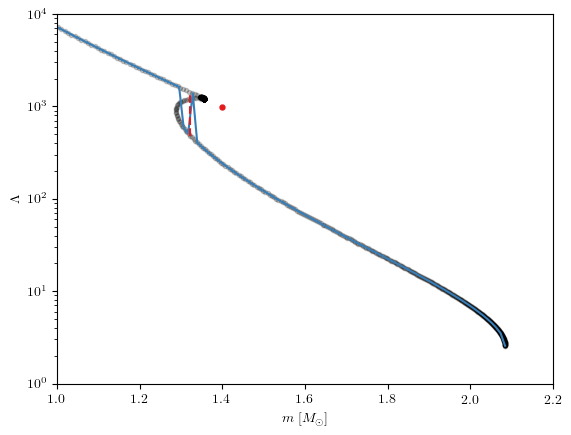

In [12]:
# extract twin star parameters and check interpolation

L14 = Lambda_of_M_base(1.4)
Mt = 0.5*(Mtwin_f + Mtwin_i)
DeltaL = Lambda_of_M_hadron(Mt)-Lambda_of_M_hybrid(Mt)

#print(L14,Mt,DeltaL)
np.savetxt(OUTDIR+'/{0}_twinstarparameters.csv'.format(eos),np.column_stack(([L14],[Mt],[DeltaL])),header='L14,Mt,DeltaL',delimiter=',',comments='')

plt.plot(np.linspace(1.,Mmax,100),[Lambda_of_M(m) for m in np.linspace(1.,Mmax,100)],c=sns.color_palette()[1])
plt.scatter(Ms,Lambdas,c='k',marker='.',alpha=0.2)
plt.scatter(1.4,L14,marker='.',s=50,c=sns.color_palette()[0])
plt.vlines(Mt,Lambda_of_M_hybrid(Mt),Lambda_of_M_hadron(Mt),linestyles='--',colors=sns.color_palette()[0])
plt.xlim(1.,2.2)
plt.ylim(1.,1e4)
plt.yscale('log')
plt.xlabel(r'$m\;[M_\odot]$')
plt.ylabel(r'$\Lambda$')
plt.savefig(OUTDIR+'/{0}_checkmLambdafit.png'.format(eos))

In [13]:
# user MCMC input

PRIOR_MMIN = 1.
PRIOR_MMAX = Mmax

PRIOR_L14MIN = 3.
PRIOR_L14MAX = 2000.
PRIOR_MtMIN = 1.
PRIOR_MtMAX = 2.
PRIOR_DeltaLMIN = 0.
PRIOR_DeltaLMAX = 1500.

START_L14 = (0.9*L14,1.1*L14)
START_Mt = (0.9*Mt,1.1*Mt)
START_DeltaL = (0.9*DeltaL,1.1*DeltaL)
if HYBRID_EOS is '': START_DeltaL = (0.,100.)

NLIKE = 1000 # number of GW likelihood samples per event
N_WALKERS = 10
N_POSTS = 20000
N_BURNIN = 100
ndims = 3

GW170817snr = 33. # GW170817 snr and parameter uncertainties for scaling GW likelihoods
GW170817dLt = 700./2
GW170817dmc = 0.005/2
GW170817dq = 0.27/2

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
/local/philippe.landry/ipykernel_16883/4231064184.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if HYBRID_EOS is '': START_DeltaL = (0.,100.)


In [14]:
# get mass samples

pop_path = OUTDIR+'/{0}_{1}_BNS_{2}_injected.csv'.format(SCENARIO,POPMOD,eos)
if not os.path.isfile(pop_path):

    m_grid = np.arange(max(MMIN,min(Ms)),min(MMAX,max(Ms)),0.001) # regular grid in NS masses

    m1m2_grid = []
    for m1 in m_grid:
        for m2 in m_grid:
            m1m2_grid += [(m1,m2)] # regular 2D grid in BNS masses

    m1s_grid = np.array([m1 for m1,m2 in m1m2_grid]) # m1 points from the 2D grid
    m2s_grid = np.array([m2 for m1,m2 in m1m2_grid]) # m2 points from the 2D grid
    grid_pts = range(len(m1m2_grid)) # label each point in 2D grid

    mparams = MPARAMS + [Mmax]
    m1m2_wts = BNS_MASS_PDF(m1s_grid,m2s_grid,mparams) # weight each binary mass grid point by its probability according to the chosen BNS mass distribution, and truncate at the EOS's Mmax

    sample_pts = np.random.choice(grid_pts,num_pop,replace=True,p=m1m2_wts/np.sum(m1m2_wts)) # draw samples from BNS mass distribution
    m1s = m1s_grid[sample_pts]
    m2s = m2s_grid[sample_pts]

In [15]:
# get corresponding Lambda samples

if not os.path.isfile(pop_path):

    Lambda1s = np.array([Lambda_of_M(m1) for m1 in m1s]) # use interpolated M-Lambda relation
    Lambda2s = np.array([Lambda_of_M(m2) for m2 in m2s])

In [16]:
# get spin samples

if not os.path.isfile(pop_path):

    chi_grid = np.arange(0.,1.,0.001) # regular grid in NS spins

    chi1_wts = SPIN_PDF(chi_grid,(0.,CHI1MAX))
    chi2_wts = SPIN_PDF(chi_grid,(0.,CHI2MAX))

    chi1s = np.random.choice(chi_grid,num_pop,replace=True,p=chi1_wts/np.sum(chi1_wts)) # draw samples from spin distributions
    chi2s = np.random.choice(chi_grid,num_pop,replace=True,p=chi2_wts/np.sum(chi2_wts))

In [17]:
# get luminosity distance samples

if not os.path.isfile(pop_path):

    dl_grid = np.arange(DLMIN,DLMAX,0.1) # regular grid in luminosity distance

    dl_wts = DL_PDF(dl_grid,(DLMIN,DLMAX))

    dls = np.random.choice(dl_grid,num_pop,replace=True,p=dl_wts/np.sum(dl_wts))

In [18]:
# sample in sky location parameters

if not os.path.isfile(pop_path):

    dec_grid = np.arange(0.,2.*np.pi,0.01)
    dec_wts = [np.abs(np.cos(dec)) for dec in dec_grid]
    decs = np.random.choice(dec_grid,num_pop,replace=True,p=dec_wts/np.sum(dec_wts))

    thetajn_grid = np.arange(0.,2.*np.pi,0.01)
    thetajn_wts = [np.abs(np.sin(thetajn)) for thetajn in thetajn_grid]
    thetajns = np.random.choice(thetajn_grid,num_pop,replace=True,p=thetajn_wts/np.sum(thetajn_wts))

    ras = np.random.uniform(0.,2.*np.pi,num_pop)
    psis = np.random.uniform(0.,np.pi,num_pop)
    phases = np.random.uniform(0.,2.*np.pi,num_pop)

In [19]:
# calculate event signal to noise ratios (SNRs) based on its source parameters

if not os.path.isfile(pop_path):

    snrs = []

    for m1,m2,chi1,chi2,Lambda1,Lambda2,dl,dec,thetajn,ra,psi,phase in zip(m1s,m2s,chi1s,chi2s,Lambda1s,Lambda2s,dls,decs,thetajns,ras,psis,phases):

      injection_parameters = dict(
        mass_1=m1, mass_2=m2, chi_1=chi1, chi_2=chi2, luminosity_distance=dl,
        theta_jn=thetajn, psi=psi, phase=phase, geocent_time=1126259642.413,
        ra=ra, dec=dec, lambda_1=Lambda1, lambda_2=Lambda2)

      duration = {'O4': 64, 'O5': 10*64, '3G': 10*64}[SCENARIO] # maximum duration of 90 min for 3G from https://arxiv.org/abs/2103.12274; 10 min should be ok for most signals though
      sampling_frequency = 2 * 1024
      start_time = injection_parameters['geocent_time'] + 2 - duration

      waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal', # note: this waveform assumes aligned spins
                              reference_frequency=50., minimum_frequency=10.0) # setting this to be lower than f_min for all of the interferometers
      waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
        waveform_arguments=waveform_arguments)

      if SCENARIO == '3G': 
        interferometers = bilby.gw.detector.InterferometerList(['CE', 'L1', 'ET'])
        interferometers[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(psd_file='/home/philippe.landry/.local/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt') # two CEs at HL sites, ET at V site
      else:
        interferometers = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])
        for interferometer in interferometers:
          #interferometer.minimum_frequency = 40 # leave this as the interferometer default, 40 Hz for O4 and 10 Hz for O5, 3G
          if SCENARIO == 'O5' and interferometer.name != 'V1': interferometer.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='/home/philippe.landry/.local/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/Aplus_asd.txt') # upgrade HL to A+ in O5
      interferometers.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration, start_time=start_time)

      injection_polarizations = waveform_generator.frequency_domain_strain(injection_parameters)
      signal_ifos = [interferometer.get_detector_response(injection_polarizations, injection_parameters) for interferometer in interferometers]

      network_snr = np.sqrt(np.sum([interferometer.optimal_snr_squared(signal=signal_ifo) for interferometer,signal_ifo in zip(interferometers,signal_ifos)])).real

      snrs += [network_snr]

In [20]:
# check population and save samples to a csv file

if not os.path.isfile(pop_path):

    plt.figure()
    plt.scatter(m1s,m2s,marker='.',color=sns.color_palette()[1]) # scatter plot of BNS masses
    plt.xlabel(r'$m_1\;[M_\odot]$')
    plt.ylabel(r'$m_2\;[M_\odot]$')
    plt.xlim(MMIN,MMAX)
    plt.ylim(MMIN,MMAX)
    plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_checkms.png'.format(SCENARIO,POPMOD,eos))

    plt.figure()
    plt.plot(Ms,Lambdas,c='k') # m1-Lambda1 and m2-Lambda2 samples overlaid on EOS's M-Lambda relation
    plt.scatter(m1s,Lambda1s,marker='.',color=sns.color_palette()[1])
    plt.scatter(m1s,Lambda1s,marker='.',color=sns.color_palette()[1])
    plt.yscale('log')
    plt.xlabel(r'$m\;[M_\odot]$')
    plt.ylabel('$\Lambda$')
    plt.xlim(MMIN,MMAX)
    plt.ylim(1.,5000.)
    plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_checkLambdas.png'.format(SCENARIO,POPMOD,eos))

    output_dat = np.column_stack((m1s,m2s,chi1s,chi2s,Lambda1s,Lambda2s,dls,snrs,decs,ras,thetajns,psis,phases)) # collect data columns into an array
    cols = 'm1,m2,chi1,chi2,Lambda1,Lambda2,dl,snr,dec,ra,theta_jn,psi,phase'
    np.savetxt(pop_path,output_dat,delimiter=',',comments='',header=cols)

In [21]:
# define transformed observables

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def q_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return mass2/mass1

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

In [22]:
# define parametric twin star M-Lambda relation model

def Lambda_of_m_twin(m,L14,Mt,DeltaL,LambdaMmax=3.):
    
    Lambda_hadron = L14*(m/1.4)**(-6)
    
    Lambda_mmax = (L14*(Mt/1.4)**(-6)- DeltaL)*(Mmax/Mt)**(-9) - LambdaMmax
    
    Lambda_hybrid = (L14*(Mt/1.4)**(-6)- DeltaL)*(m/Mt)**(-9) - Lambda_mmax*((m-Mt)/(Mmax-Mt))
    
    return np.where(m > Mt,Lambda_hybrid,Lambda_hadron)

In [23]:
# define likelihood function and prior for MCMC

def logprior(theta,lambdaa):
    
    L14, Mt, DeltaL = theta
    mmin, mmax = lambdaa
    
    if Lambda_of_m_twin(1.01*Mt, L14, Mt, DeltaL) < 0.: return -np.inf
    
    L14prior = np.where((L14 < PRIOR_L14MIN) or (L14 > PRIOR_L14MAX), 0., 1./(PRIOR_L14MAX-PRIOR_L14MIN))
    Mtprior = np.where((Mt < PRIOR_MtMIN) or (Mt > PRIOR_MtMAX), 0., 1./(PRIOR_MtMAX-PRIOR_MtMIN))
    DeltaLprior = np.where((DeltaL < PRIOR_DeltaLMIN) or (DeltaL > PRIOR_DeltaLMAX), 0., 1./(PRIOR_DeltaLMAX-PRIOR_DeltaLMIN))
    
    log_prior = np.log(L14prior*Mtprior*DeltaLprior)
    
    return log_prior

def loglikelihood(theta,d,msamps):
    
    L14, Mt, DeltaL = theta
    
    m1_samps, m2_samps, mc_samps, q_samps = msamps
    
    L1_samps = Lambda_of_m_twin(m1_samps,L14,Mt,DeltaL)
    L2_samps = Lambda_of_m_twin(m2_samps,L14,Mt,DeltaL)
    Lt_samps = lambdatilde(L1_samps,L2_samps,m1_samps,m2_samps)
    
    one_event_likes = []
    j = 0
    for one_event_d in d:
        
        mc_mean,dmc,q_mean,dq,Lt_mean,dLt = one_event_d
    
        mc_gaussian = stats.norm.pdf(mc_samps,loc=mc_mean,scale=dmc/1.645)
        q_gaussian = stats.norm.pdf(q_samps,loc=q_mean,scale=dq/1.645)
        Lt_gaussian = stats.norm.pdf(Lt_samps,loc=Lt_mean,scale=dLt/1.645)
            
        likes = mc_gaussian*q_gaussian*Lt_gaussian
        one_event_likes += [np.sum(likes)]
        
        j = j+1
        
    log_like = np.log(np.prod(one_event_likes))
    
    return log_like

def logposterior(theta,d,lambdaa,msamps):
    
    log_prior = logprior(theta,lambdaa)
    
    if not np.isfinite(log_prior): return -np.inf

    log_like = loglikelihood(theta,d,msamps)
    
    return log_like + log_prior

datatype = [("L14", float), ("Mt", float), ("DeltaL", float)]

In [24]:
# load observations

pop = np.genfromtxt(pop_path,names=True,delimiter=',',dtype=None,encoding=None) # load population

snrs = pop['snr']
m1s = pop['m1']
m2s = pop['m2']
L1s = pop['Lambda1']
L2s = pop['Lambda2']
chi1s = pop['chi1']
chi2s = pop['chi2']
dls = pop['dl']
decs = pop['dec']
ras = pop['ra']
thetajns = pop['theta_jn']
psis = pop['psi']
phases = pop['phase']

mcs = mchirp_from_mass1_mass2(m1s,m2s)
qs = q_from_mass1_mass2(m1s,m2s)
Lts = lambdatilde(L1s,L2s,m1s,m2s)

dmcs = [GW170817dmc*GW170817snr/snr for snr in snrs]
dqs = [GW170817dq*GW170817snr/snr for snr in snrs]
dLts = [GW170817dLt*GW170817snr/snr for snr in snrs]

mc_means = np.array([mc + NOISE*np.random.normal(0.,dmc/1.645) for mc,dmc in zip(mcs,dmcs)])
q_means = np.array([q + NOISE*np.random.normal(0.,dq/1.645) for q,dq in zip(qs,dqs)])
Lt_means = np.array([Lt + NOISE*np.random.normal(0.,dLt/1.645) for Lt,dLt in zip(Lts,dLts)])

inj = []
d = [] 
for k,(snr,mc_mean,dmc,q_mean,dq,Lt_mean,dLt) in enumerate(zip(snrs,mc_means,dmcs,q_means,dqs,Lt_means,dLts)):

        if k > detailed_num_pop: break

        if snr <= DET_THRES: continue # impose detection threshold snr
        
        d += [[mc_mean,dmc,q_mean,dq,Lt_mean,dLt]]
        inj += [[mcs[k],dmcs[k],qs[k],dqs[k],Lts[k],dLts[k]]]
        
inj = np.array(inj)
d = np.array(d)

np.savetxt(OUTDIR+'/{0}_{1}_BNS_{2}_detected-{3}.csv'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG),np.column_stack((inj[:,0],d[:,0],d[:,1],inj[:,2],d[:,2],d[:,3],inj[:,4],d[:,4],d[:,5])),delimiter=',',comments='',header='mc,mc_det,dmc,q,q_det,dq,Lt,Lt_det,dLt')

In [25]:
# draw samples from population model

PRIOR_MMAX = Mmax

mA_samps = np.random.uniform(max(MMIN,PRIOR_MMIN),min(MMAX,PRIOR_MMAX),NLIKE)
mB_samps = np.random.uniform(max(MMIN,PRIOR_MMIN),min(MMAX,PRIOR_MMAX),NLIKE)

m1_samps = np.array([max(mA,mB) for mA,mB in zip(mA_samps,mB_samps)])
m2_samps = np.array([min(mA,mB) for mA,mB in zip(mA_samps,mB_samps)])

mc_samps = mchirp_from_mass1_mass2(m1_samps,m2_samps)
q_samps = q_from_mass1_mass2(m1_samps,m2_samps)

In [26]:
results_path = OUTDIR+'/{0}_{1}_BNS_{2}_recovery-{3}.csv'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG)

lambdaa = (MMIN, MMAX)
msamps = (m1_samps, m2_samps, mc_samps, q_samps)

loglikelihood.ncalls = 0
argslist = (d,lambdaa,msamps)

theta_i = []
for i in range(N_WALKERS):
    
    L14_i, Mt_i, DeltaL_i = 0., MMIN, 5e4
    
    while Lambda_of_m_twin(1.01*Mt_i, L14_i, Mt_i, DeltaL_i) < 0.:

        L14_i = np.random.uniform(*START_L14)
        Mt_i = np.random.uniform(*START_Mt)
        DeltaL_i = np.random.uniform(*START_DeltaL)
    
    theta_i += [[L14_i,Mt_i,DeltaL_i]]
    
ini_thetas = np.array(theta_i)

sampler = emcee.EnsembleSampler(N_WALKERS, ndims, logposterior, args=argslist, blobs_dtype=datatype)

t0 = time()
sampler.run_mcmc(ini_thetas, N_POSTS+N_BURNIN) # do the mcmc with emcee
t1 = time()
timeemcee = (t1-t0)

acls = sampler.get_autocorr_time(quiet=True)
#print('Maximum chain autocorrelation lengths for parameters: {0}'.format(acls))

if np.all(np.isfinite(acls)):
    
    samples_emcee = sampler.chain[:, N_BURNIN::int(max(acls)), :].reshape((-1, ndims))
    num_samples_emcee = len(samples_emcee)
    ess = int(num_samples_emcee / timeemcee)
    
    #print('Number of posterior samples, runtime and effective samples per second: {0}, {1}, {2}'.format(num_samples_emcee,timeemcee,ess))
    
    L14s = samples_emcee[:,0]
    Mts = samples_emcee[:,1]
    DeltaLs = samples_emcee[:,2]
    
    post_dict = {'L14': L14s, 'Mt': Mts, 'DeltaL': DeltaLs}
    post = pd.DataFrame(data=post_dict)
    
    np.savetxt(results_path,np.column_stack((L14s,Mts,DeltaLs)),header='L14,Mt,DeltaL',comments='',delimiter=',')

else: assert 0 == 1, "MCMC failed to converge"

/local/philippe.landry/ipykernel_16883/2700300414.py:14: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(L14prior*Mtprior*DeltaLprior)


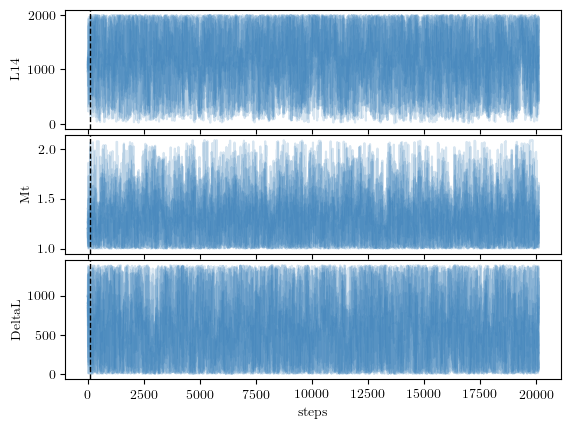

In [27]:
def trace_plot(raw_samples,param_names,num_burn=False):

    fig = plt.figure()
    gs = gridspec.GridSpec(ndims, 1)
    axs = [plt.subplot(gs[i]) for i in range(ndims)]
    plt.subplots_adjust(hspace=0.05)
    
    for i,ax in enumerate(axs):
        for chain_samples in raw_samples: ax.plot(chain_samples[:,i], c=sns.color_palette()[1], alpha=0.2)
        ax.set_ylabel(param_names[i])
        if num_burn: ax.axvline(num_burn,lw=1,ls='--',c='k')
        if i < len(axs)-1: ax.tick_params(labelbottom=False)
        
    axs[-1].set_xlabel('steps')

    return plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_traces-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))

trace_plot(sampler.chain,['L14','Mt','DeltaL'],N_BURNIN)

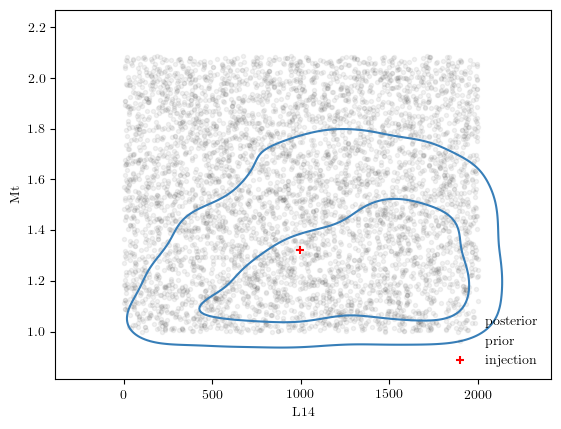

In [28]:
sns.kdeplot(x=post['L14'],y=post['Mt'],levels=[0.1,0.5],label='posterior',color=sns.color_palette()[1])
plt.scatter(np.random.uniform(PRIOR_L14MIN,PRIOR_L14MAX,5000),np.random.uniform(PRIOR_MtMIN,PRIOR_MtMAX,5000),marker='.',c='k',alpha=0.05,label='prior')
plt.scatter(L14,Mt,marker='+',c='r',label='injection')
plt.legend(frameon=False)
plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_L14Mtwin-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))

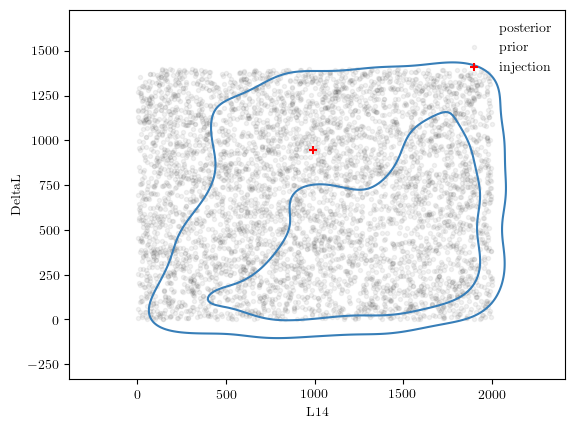

In [29]:
sns.kdeplot(x=post['L14'],y=post['DeltaL'],levels=[0.1,0.5],label='posterior',color=sns.color_palette()[1],)
plt.scatter(np.random.uniform(PRIOR_L14MIN,PRIOR_L14MAX,5000),np.random.uniform(PRIOR_DeltaLMIN,PRIOR_DeltaLMAX,5000),marker='.',c='k',alpha=0.05,label='prior')
plt.scatter(L14,DeltaL,marker='+',c='r',label='injection')
plt.legend(frameon=False)
plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_L14DeltaL-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))

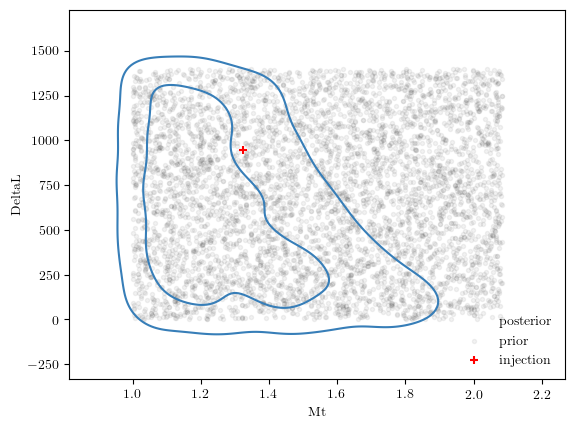

In [30]:
sns.kdeplot(x=post['Mt'],y=post['DeltaL'],levels=[0.1,0.5],label='posterior',color=sns.color_palette()[1],)
plt.scatter(np.random.uniform(PRIOR_MtMIN,PRIOR_MtMAX,5000),np.random.uniform(PRIOR_DeltaLMIN,PRIOR_DeltaLMAX,5000),marker='.',c='k',alpha=0.05,label='prior')
plt.scatter(Mt,DeltaL,marker='+',c='r',label='injection')
plt.legend(frameon=False)
plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_MtDeltaL-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))

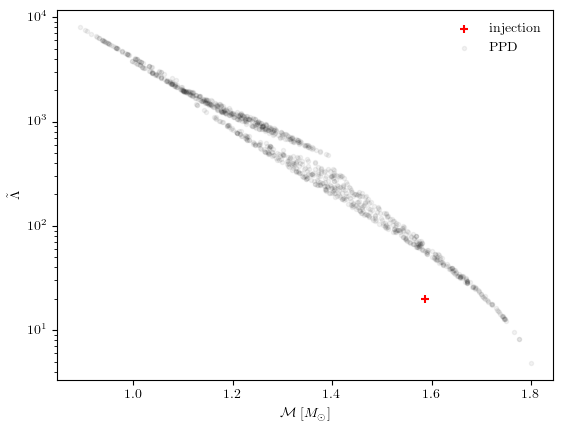

In [31]:
medL14 = np.median(L14s)
medMt = np.median(Mts)
medDeltaL = np.median(DeltaLs)
#print(medL14,medMtwin,medDeltaL)

plt.scatter(inj[:,0],inj[:,4],marker='+',c='r',alpha=1.,label='injection')
plt.scatter(mc_samps,lambdatilde(Lambda_of_m_twin(m1_samps,medL14,medMt,medDeltaL),Lambda_of_m_twin(m2_samps,medL14,medMt,medDeltaL),m1_samps,m2_samps),marker='.',c='k',alpha=0.05,label='PPD')

plt.xlabel(r'$\mathcal{M}\;[M_\odot]$')
plt.ylabel(r'$\tilde{\Lambda}$')
plt.yscale('log')

plt.legend(frameon=False)
plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_MchirpLambdatilde-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))

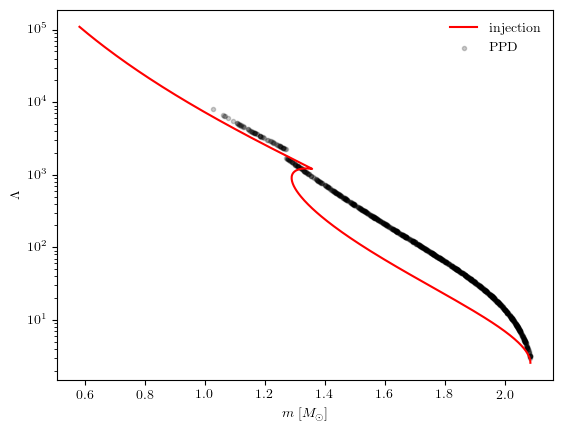

In [32]:
plt.plot(Ms,Lambdas,c='r',alpha=1.,label='injection')
plt.scatter(m1_samps,Lambda_of_m_twin(m1_samps,medL14,medMt,medDeltaL),marker='.',c='k',alpha=0.2,label='PPD')

plt.xlabel(r'$m\;[M_\odot]$')
plt.ylabel(r'$\Lambda$')
plt.yscale('log')

plt.legend(frameon=False)
plt.savefig(OUTDIR+'/{0}_{1}_BNS_{2}_mLambda-{3}.png'.format(SCENARIO,POPMOD,eos,SCENARIO+SCENARIOTAG))